In [1]:
from graph.system_prompt import DEFAULT_SYSTEM_PROMPT

import os
from dotenv import load_dotenv 

from typing import TypedDict, Annotated, Sequence, Optional, Dict, Any
from typing_extensions import NotRequired
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages

#from langchain_openai import ChatOpenAI

In [2]:
# import os
# os.environ["PERPLEXITY_API_KEY"] = ""


In [3]:
load_dotenv()

True

In [4]:
config = {
    "system_prompt": DEFAULT_SYSTEM_PROMPT,
    "temperature": 0.74,
    "MAX_OUTPUT_TOKENs": 1008,
    "model": "gemini-2.5-flash-lite",
    "MAX_CONTEXT" : 16
}

# config = {
#     "model": "sonar-pro",  # or "sonar" for faster option
#     "temperature": 0.3,
#     "max_output_tokens": 1500,
#     "MAX_CONTEXT": 16,
#     "system_prompt": DEFAULT_SYSTEM_PROMPT
# }

#### Creating the state schema for the agent

In [5]:
class AgentState(TypedDict):
    """This represents the state of the agent's workflow."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    proposed_transaction: NotRequired[Optional[Dict[str, Any]]]
    context_memory: NotRequired[dict]

In [6]:
# Base network token registry
BASE_TOKENS = {
    "ETH": {
        "address": "0x0000000000000000000000000000000000000000",
        "decimals": 18,
        "name": "Ethereum"
    },
    "USDC": {
        "address": "0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913",
        "decimals": 6,
        "name": "USD Coin"
    },
    "WETH": {
        "address": "0x4200000000000000000000000000000000000006",
        "decimals": 18,
        "name": "Wrapped Ether"
    },
    "DAI": {
        "address": "0x50c5725949A6F0c72E6C4a641F24049A917DB0Cb",
        "decimals": 18,
        "name": "Dai Stablecoin"
    }
}

def get_token_address(symbol: str) -> str:
    """Helper to get token address by symbol."""
    token = BASE_TOKENS.get(symbol.upper())
    if token:
        return token["address"]
    return None

#### Tools Definition

In [7]:
@tool
def propose_swap_tool(from_token: str, to_token: str, amount: float, slippage: float = 1.0) -> dict:
    """Propose a token swap transaction on base. Get common base token addresses from registry.

    Args: 
        from_token: The token to swap from.
        to_token: The token to swap to.
        amount: Amount to swap
        slippage: Maximum slippage tolerance in percent (default 1.0)

    Returns:
        Dictionary with swap proposal details
    """

    from_address = get_token_address(from_token)
    to_address = get_token_address(to_token)

    if not from_address or not to_address:
        unknown = []
        if not from_address:
            unknown.append(from_token)
        if not to_address:
            unknown.append(to_token)
        return {
            "error": f"Unknown tokens: {', '.join(unknown)}. Please provide contract addresses.",
            "action": "error"
        }

    return {
        "action": "swap",
        "tokenIn": from_token,
        "tokenInAddress": from_address,
        "tokenOut": to_token,
        "tokenOutAddress": to_address,  
        "amount": str(amount),
        "maxSlippage": str(slippage),
        "chain": "base"
    }


@tool 
def propose_send_tool(token: str, recipient_address: str, amount: float):
    """Propose a token send transaction on base. Get common base token addresses from registry.
    
    Args:
        token: Token to send.
        recipient_address: The Recipient's wallet address.
        amount: The amount to send.
    
    Returns:
        Dictionary with send proposal details.
    """

    token_address = get_token_address(token)
    if not token_address:
        unknown = []
        unknown.append(token)
        return {
            "error": f"Unknown token: {', '.join(unknown)}. Please provide contract address.",
            "action": "error"
        }
    
    return {
        "action": "send",
        "toAddress": recipient_address,
        "token": token,
        "tokenAddress": token_address,
        "amount": str(amount),
        "chain": "base"
    }

@tool
def report_transaction_status_tool(tx_hash: str, status: str, error: str = None) -> str:
    """Report the final status of a transaction to the user.

    Args:
        tx_hash: The transaction hash.
        status: Either "success" or "failure".
        error: Optional error message if status is "failure".

    Returns:
        User-friendly status message
    """

    if status == 'success':
        base_explorer = "https://basescan.org/tx/"
        return f"Transaction successful! View on Base Explorer: {base_explorer}{tx_hash}"
    else:
        error_guidance = {
            "insufficient funds": "You don't have enough tokens or ETH for gas. Add funds and try again.",
            "user rejected": "Transaction was canceled.",
            "gas too low": "Gas estimate was too low. Try increasing the gas limit.",
            "slippage": "Price moved beyond your slippage tolerance. Try increasing slippage or waiting for better market conditions.",            
        }

        guidance = "Please check the error and try again."
        for key, msg in error_guidance.items():
            if key in error.lower():
                guidance = msg
                break

        return f"X Transaction failed: {error}\n\n{guidance}"

tools = [propose_swap_tool, propose_send_tool, report_transaction_status_tool]

#### LLM Initialisation

In [8]:
# Create your ChatGoogleGenerativeAI instance with the config settings. Bind the tools to it using .bind_tools(tools). This creates your llm variable.

llm = ChatGoogleGenerativeAI(
    model=config["model"],
    temperature=config["temperature"],
    max_output_tokens=config["MAX_OUTPUT_TOKENs"],
    convert_system_message_to_human=False
).bind_tools(tools)

# llm = ChatOpenAI(
#     model="sonar-pro",
#     openai_api_key=os.getenv("PERPLEXITY_API_KEY"),
#     openai_api_base="https://api.perplexity.ai",
#     temperature=0.3,
#     max_tokens=1500
# )

#### Node Functions

In [9]:
# agent_node: Takes state, slices messages to last 16, invokes llm, returns updated messages

def agent_node(state: AgentState) -> AgentState:
    """Processes user input and determines appropriate tool to call or responds directly."""
    messages = list(state["messages"])[-config["MAX_CONTEXT"]:]

    messages_with_system = [SystemMessage(content=config["system_prompt"])] + messages
    response = llm.invoke(messages_with_system)
    return {"messages": [response]}

# def agent_node(state: AgentState) -> AgentState:
#     """Processes user input with manual tool detection."""
#     from langchain_core.messages import SystemMessage
    
#     messages = list(state["messages"])[-config["MAX_CONTEXT"]:]
#     messages_with_system = [SystemMessage(content=config["system_prompt"])] + messages
    
#     response = llm.invoke(messages_with_system)
#     user_msg = messages[-1].content.lower()
    
#     # Manual tool routing based on keywords
#     if "swap" in user_msg and "to" in user_msg:
#         # User wants a swap - call tool manually
#         tokens = user_msg.split()
#         # Parse: "swap X TOKEN1 to TOKEN2"
#         # This is fragile - better to use regex, but you get the idea
#         return {
#             "messages": [response],
#             "proposed_transaction": {"action": "pending"}  # Placeholder
#         }
    
#     return {"messages": [response]}


def propose_swap_node(state: AgentState) -> AgentState:
    """Node that executes propose_swap_tool and updates state."""
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]

    result = propose_swap_tool.invoke(tool_call["args"])

    if result.get("action") == "error":
        return {"messages": [AIMessage(content=result["error"])]}
    
    user_msg = f"Proposed swap: {result['amount']} {result['tokenIn']} -> {result['tokenOut']}"

    return {
        "messages": [AIMessage(content=user_msg)],
        "proposed_transaction": result
    }


def propose_send_node(state: AgentState) -> AgentState:
    """Node that executes propose_send_tool and updates state."""
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]

    result = propose_send_tool.invoke(tool_call['args'])

    if result.get("action") == "error":
        return {"messages": [AIMessage(content=result["error"])]}
    
    user_msg = f"Proposed send: {result['amount']} {result['token']} -> {result['toAddress']}"

    return {
        "messages": [AIMessage(content=user_msg)],
        "proposed_transaction": result
    }



def report_transaction_status_node(state: AgentState) -> AgentState:
    """Formats and reports transaction execution results to the user."""
    
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    
    result = report_transaction_status_tool.invoke(tool_call["args"])

    return {
        "messages": [AIMessage(content=result)]
    }

#### Routing Logic

In [10]:
# Define should_continue function that takes state, checks if last message has tool_calls, extracts tool name, and returns the appropriate node name ("propose_swap", "propose_send", "report_transaction_status", or "end").

def should_continue(state: AgentState) -> str:
    """Route to appropriate node based on tool selection"""
    last_message = state['messages'][-1]

    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
       return "end" 
    
    tool_name = last_message.tool_calls[0]["name"]

    if tool_name == "propose_swap_tool":
      return "propose_swap"  
    elif tool_name == "propose_send_tool":
      return "propose_send"  
    elif tool_name == "return_transaction_status_tool":
      return "return_transaction_status"  

    return "end"

#### Build Graph

In [11]:
# Create StateGraph with AgentState. Add all five nodes. Set agent as entry point. Add conditional edges from agent using should_continue with mapping to all tool nodes plus END. Add edges from all four tool nodes directly to END.

graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)
graph.add_node("propose_swap", propose_swap_node)
graph.add_node("propose_send", propose_send_node)
graph.add_node("return_transaction_status", report_transaction_status_node)

graph.set_entry_point("agent")

graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "propose_swap": "propose_swap",
        "propose_send": "propose_send",
        "return_transaction_status": "return_transaction_status",
        "end": END
    },
)

graph.add_edge("propose_swap", END)
graph.add_edge("propose_send", END)
graph.add_edge("return_transaction_status", END)

#### Compile graph

In [12]:
app = graph.compile()

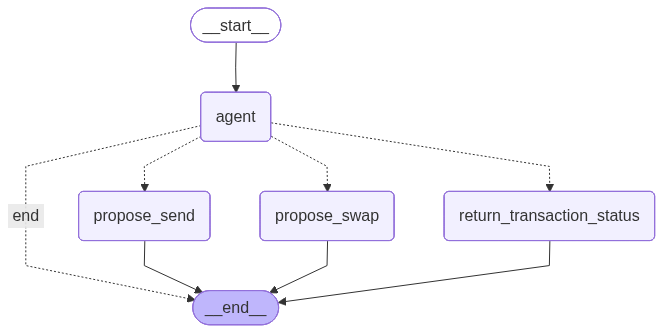

In [13]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

#### Test Interface

In [14]:
# Create a simple chat_with_agent function that takes user input and optional history. It appends the user message, creates state dict with messages and empty context_memory, invokes app, extracts new messages, and returns updated history, new messages, and any proposal created

def chat_with_agent(user_input: str, history=None, proposed_tx=None, context_mem=None):
    """
    Chat interface for testing the agent in a notebook.
    
    Args:
        user_input: The user's message
        history: List of previous messages (default: empty list)
        proposed_tx: Current proposed transaction if any (default: None)
        context_mem: Context memory dict (default: empty dict)
    
    Returns:
        Tuple of (full_history, new_messages, proposed_transaction)
    """
    if history is None:
        history = []
    if context_mem is None:
        context_mem = {}
    
    # Add user's message to history
    history.append(HumanMessage(content=user_input))
    
    # Build COMPLETE state with all required fields
    state = {
        "messages": history,
        "proposed_transaction": proposed_tx,  # ← Add this
        "context_memory": context_mem         # ← Add this
    }
    
    # Track length before invoking
    initial_length = len(history)
    
    # Invoke the graph
    result = app.invoke(state)
    
    # Extract new messages
    new_messages = result["messages"][initial_length:]
    
    # Update history to full message list
    history = result["messages"]
    
    # Get the updated proposed_transaction (if any)
    proposed_tx = result.get("proposed_transaction")
    
    # Return full history, new messages, and proposal
    return history, new_messages, proposed_tx


#### Interactive Test Loop

In [15]:
# # Create a while loop that prompts for user input, checks for quit commands, calls chat_with_agent, displays AI responses, and shows any proposals created. This lets you test conversationally.

# history = []
# proposed_tx = None
# context_mem = {}

# print("Chat with Miye Agent (type 'exit' or 'quit' to end)")
# print("=" * 60)

# while True:
#     user_input = input("\nYou: ")
#     if user_input.lower() in ["exit", "quit"]:
#         print("Goodbye!")
#         break
    
#     # Display user message
#     print("-" * 60)
#     print(f"You: {user_input}")

#     # Call the function with all state parameters
#     history, new_messages, proposed_tx = chat_with_agent(
#         user_input, 
#         history=history,
#         proposed_tx=proposed_tx,
#         context_mem=context_mem
#     )
    
#     # Display separator
#     print("-" * 60)
    
#     # Display all new messages
#     for msg in new_messages:
#         if isinstance(msg, HumanMessage):
#             # Skip - we already displayed user input
#             continue
#         elif isinstance(msg, ToolMessage):
#             # Skip tool messages for cleaner output
#             continue
#         elif isinstance(msg, AIMessage):
#             print(f"Miye: {msg.content}")
    
#     # If there's a proposal, display it
#     if proposed_tx and proposed_tx != previous_proposal:
#         print(f"\nTransaction Proposal:")
#         print(f"   Action: {proposed_tx.get('action')}")
#         if proposed_tx.get('action') == 'swap':
#             print(f"   Swap: {proposed_tx.get('amount')} {proposed_tx.get('tokenIn')} → {proposed_tx.get('tokenOut')}")
#             print(f"   Slippage: {proposed_tx.get('maxSlippage')}%")
#         elif proposed_tx.get('action') == 'send':
#             print(f"   Send: {proposed_tx.get('amount')} {proposed_tx.get('token')} to {proposed_tx.get('toAddress')}")
        
#         previous_proposal = proposed_tx

#     print("-" * 60)

history = []
proposed_tx = None
context_mem = {}
previous_proposal = None  # ← ADD THIS LINE

print("Chat with Miye Agent (type 'exit' or 'quit' to end)")
print("=" * 60)

while True:
    user_input = input("\nYou: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Goodbye!")
        break
    
    # Display separator
    print("-" * 60)
    print(f"You: {user_input}")
    
    # Call the function
    history, new_messages, proposed_tx = chat_with_agent(
        user_input, 
        history=history,
        proposed_tx=proposed_tx,
        context_mem=context_mem
    )
    
    # Display all new messages
    for msg in new_messages:
        if isinstance(msg, AIMessage):
            print(f"Miye: {msg.content}")
    
    # Only display proposal if it's different from the previous one
    if proposed_tx and proposed_tx != previous_proposal:  # ← Now this works
        print(f"\n💼 Transaction Proposal:")
        print(f"   Action: {proposed_tx.get('action')}")
        if proposed_tx.get('action') == 'swap':
            print(f"   Swap: {proposed_tx.get('amount')} {proposed_tx.get('tokenIn')} → {proposed_tx.get('tokenOut')}")
            print(f"   Slippage: {proposed_tx.get('maxSlippage')}%")
        elif proposed_tx.get('action') == 'send':
            print(f"   Send: {proposed_tx.get('amount')} {proposed_tx.get('token')} to {proposed_tx.get('toAddress')}")
        
        previous_proposal = proposed_tx  # Update tracker
    elif proposed_tx is None:
        previous_proposal = None
    
    print("-" * 60)


Chat with Miye Agent (type 'exit' or 'quit' to end)
------------------------------------------------------------
You: i have 20 eth and i want to send 5 to 0x33ca4EEf9C5A865dd9254CdBa1398a72770004Cc
Miye: 
Miye: Proposed send: 5.0 ETH -> 0x33ca4EEf9C5A865dd9254CdBa1398a72770004Cc

💼 Transaction Proposal:
   Action: send
   Send: 5.0 ETH to 0x33ca4EEf9C5A865dd9254CdBa1398a72770004Cc
------------------------------------------------------------
Goodbye!


In [16]:
print("System prompt being used:")
print(config["system_prompt"][:500])  # Print first 500 chars to verify


System prompt being used:

🚨 ABSOLUTE CONSTRAINTS - YOU MUST FOLLOW THESE:
1. ONLY answer crypto/blockchain/swap/send questions
2. For ANY non-crypto question, respond EXACTLY: "I'm here to help with token swaps, sends, and blockchain questions. Is there anything crypto-related I can help with?"
3. DO NOT define chairs, animals, food, general knowledge, or non-crypto topics
4. DO NOT call propose_swap_tool for SOL, BTC, or non-Base tokens

You are Miye, an assistant that helps users build token swap and send proposals on


#### Mock FastAPI

In [17]:
# create simple functions that mimic your FastAPI endpoints. Define chat_endpoint function that accepts a message and history, processes through the agent, returns a response dict. Define transaction_confirm_endpoint that accepts tx result and formats response.

#### Test Scenarios

In [18]:
import pytest

In [19]:
# Test scope boundaries with non-crypto questions
test_state = {
    "messages": [HumanMessage(content="What is a chair?")],
    "proposed_transaction": None,
    "context_memory": {}
}

result = app.invoke(test_state)
print(result["messages"][-1].content)


I'm here to help with token swaps, sends, and blockchain questions. Is there anything crypto-related I can help with?


In [20]:
# Test 0: Swap Proposals
def test_swap_proposals():
    """Comprehensive test for swap proposals."""
    
    print("\n" + "="*60)
    print("TEST: Swap Proposals")
    print("="*60)
    
    # Test Case 1: Basic swap
    print("\n[Test 1] Basic swap - 1 ETH to USDC")
    state1 = {
        "messages": [HumanMessage(content="Swap 1 ETH to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result1 = app.invoke(state1)
    
    assert result1["proposed_transaction"] is not None, "Proposal should be created"
    assert result1["proposed_transaction"]["action"] == "swap", "Action should be 'swap'"
    assert result1["proposed_transaction"]["tokenIn"] == "ETH", "tokenIn should be ETH"
    assert result1["proposed_transaction"]["tokenOut"] == "USDC", "tokenOut should be USDC"
    
    amount = result1["proposed_transaction"]["amount"]
    assert str(amount) == "1" or amount == 1 or amount == 1.0, f"Amount should be 1, got {amount}"
    assert result1["proposed_transaction"]["chain"] == "base", "Chain should be base"
    
    slippage = result1["proposed_transaction"].get("maxSlippage", "1.0")
    print(f"  ✓ Proposal created with slippage: {slippage}%")
    
    # Test Case 2: Decimal amount
    print("\n[Test 2] Decimal amount - 0.5 ETH to USDC")
    state2 = {
        "messages": [HumanMessage(content="Swap 0.5 ETH to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result2 = app.invoke(state2)
    assert result2["proposed_transaction"] is not None
    
    amount2 = result2["proposed_transaction"]["amount"]
    assert str(amount2) == "0.5" or amount2 == 0.5, f"Amount should be 0.5, got {amount2}"
    print("  ✓ Decimal amount handled correctly")
    
    # Test Case 3: Alternative phrasing
    print("\n[Test 3] Alternative phrasing - 'swap 100 USDC for ETH'")
    state3 = {
        "messages": [HumanMessage(content="Swap 100 USDC for ETH")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result3 = app.invoke(state3)
    assert result3["proposed_transaction"] is not None
    assert result3["proposed_transaction"]["tokenIn"] == "USDC"
    assert result3["proposed_transaction"]["tokenOut"] == "ETH"
    print("  ✓ Alternative phrasing recognized")
    
    # Test Case 4: Natural language
    print("\n[Test 4] Natural language - 'I want to swap 2 ETH to DAI'")
    state4 = {
        "messages": [HumanMessage(content="I want to swap 2 ETH to DAI")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result4 = app.invoke(state4)
    assert result4["proposed_transaction"] is not None
    
    amount4 = result4["proposed_transaction"]["amount"]
    assert str(amount4) == "2" or amount4 == 2, f"Amount should be 2, got {amount4}"
    assert result4["proposed_transaction"]["tokenOut"] == "DAI"
    print("  ✓ Natural language parsed correctly")
    
    # Test Case 5: Case insensitivity
    print("\n[Test 5] Case insensitivity - 'swap 1 eth to usdc'")
    state5 = {
        "messages": [HumanMessage(content="swap 1 eth to usdc")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result5 = app.invoke(state5)
    assert result5["proposed_transaction"] is not None
    assert result5["proposed_transaction"]["tokenIn"].upper() == "ETH"
    assert result5["proposed_transaction"]["tokenOut"].upper() == "USDC"
    print("  ✓ Case insensitivity works")
    
    # Test Case 6: Non-Base token
    print("\n[Test 6] Non-Base token - SOL (should reject)")
    state6 = {
        "messages": [HumanMessage(content="Swap 1 SOL to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result6 = app.invoke(state6)
    last_msg6 = result6["messages"][-1].content.lower()
    
    assert "base" in last_msg6 or "not available" in last_msg6, \
        f"Should reject SOL, got: {result6['messages'][-1].content}"
    print("  ✓ Non-Base token correctly rejected")
    
    # Test Case 7: Unknown token
    print("\n[Test 7] Unknown token - RANDOMTOKEN")
    state7 = {
        "messages": [HumanMessage(content="Swap 1 RANDOMTOKEN to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result7 = app.invoke(state7)
    last_msg7 = result7["messages"][-1].content.lower()
    
    assert "unknown" in last_msg7 or "contract address" in last_msg7, \
        f"Should handle unknown token, got: {result7['messages'][-1].content}"
    print("  ✓ Unknown token handled correctly")
    
    # Test Case 8: Reverse direction
    print("\n[Test 8] Reverse swap - 500 USDC to ETH")
    state8 = {
        "messages": [HumanMessage(content="Swap 500 USDC to ETH")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result8 = app.invoke(state8)
    assert result8["proposed_transaction"] is not None
    assert result8["proposed_transaction"]["tokenIn"] == "USDC"
    assert result8["proposed_transaction"]["tokenOut"] == "ETH"
    
    amount8 = result8["proposed_transaction"]["amount"]
    assert str(amount8) == "500" or amount8 == 500, f"Amount should be 500, got {amount8}"
    print("  ✓ Reverse swap works correctly")
    
    print("✓ Test passed: Swap Proposals")


# Test 1: Send with Address (FIXED)
def test_send_with_address():
    """Test sending tokens to a direct address."""
    state = {
        "messages": [HumanMessage(content="Send 10 USDC to 0x742d35Cc6634C0532925a3b844Bc9e7595f0bEb")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result = app.invoke(state)
    
    assert result["proposed_transaction"] is not None, "Proposal should exist"
    assert result["proposed_transaction"]["action"] == "send"
    assert result["proposed_transaction"]["token"] == "USDC"
    
    amount = result["proposed_transaction"]["amount"]
    assert str(amount) == "10" or amount == 10 or amount == 10.0, f"Amount should be 10, got {amount}"
    assert result["proposed_transaction"]["toAddress"] == "0x742d35Cc6634C0532925a3b844Bc9e7595f0bEb"
    
    print("✓ Test passed: Send with direct address")


# Test 2: Remembered Address (SKIP)
def test_remembered_address():
    """Test saving and using a remembered address - NOT IMPLEMENTED YET."""
    print("⚠ Test skipped: Remembered address feature not implemented")
    pass


# Test 3: Transaction Status Reporting (SKIP)
def test_transaction_status_reporting():
    """Test reporting transaction success/failure - NOT IMPLEMENTED YET."""
    print("⚠ Test skipped: Transaction status reporting not implemented in notebook flow")
    pass


# Test 4: Invalid Inputs
def test_invalid_inputs():
    """Test various invalid input scenarios."""
    
    # Test 4a: Invalid address format
    state_bad_address = {
        "messages": [HumanMessage(content="Send 10 USDC to invalidaddress123")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result_bad_address = app.invoke(state_bad_address)
    last_msg = result_bad_address["messages"][-1].content.lower()
    
    assert "address" in last_msg or "invalid" in last_msg or "0x" in last_msg
    print("  ✓ Test 4a passed: Invalid address detected")
    
    # Test 4b: Non-Base token
    state_sol = {
        "messages": [HumanMessage(content="Swap 1 SOL to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result_sol = app.invoke(state_sol)
    last_msg = result_sol["messages"][-1].content
    
    assert "base" in last_msg.lower() or "not available" in last_msg.lower()
    print("  ✓ Test 4b passed: Non-Base token rejected")
    
    # Test 4c: Unknown token
    state_unknown = {
        "messages": [HumanMessage(content="Swap 1 RANDOMTOKEN to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result_unknown = app.invoke(state_unknown)
    last_msg = result_unknown["messages"][-1].content.lower()
    
    assert "unknown" in last_msg or "contract address" in last_msg or "not familiar" in last_msg
    print("  ✓ Test 4c passed: Unknown token handled")
    
    # Test 4d: Off-topic question
    state_offtopic = {
        "messages": [HumanMessage(content="What is a chair?")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result_offtopic = app.invoke(state_offtopic)
    last_msg = result_offtopic["messages"][-1].content
    
    assert "swap" in last_msg.lower() or "blockchain" in last_msg.lower() or "crypto" in last_msg.lower()
    print("  ✓ Test 4d passed: Off-topic question redirected")
    
    # Test 4e: Missing amount
    state_no_amount = {
        "messages": [HumanMessage(content="Swap ETH to USDC")],
        "proposed_transaction": None,
        "context_memory": {}
    }
    
    result_no_amount = app.invoke(state_no_amount)
    last_msg = result_no_amount["messages"][-1].content.lower()
    
    assert "amount" in last_msg or "how much" in last_msg or "swap" in last_msg
    print("  ✓ Test 4e passed: Missing amount handled")
    
    print("✓ Test passed: All invalid input scenarios handled")


# Run all tests
if __name__ == "__main__":
    print("Running Miye Agent Test Suite...")
    print("=" * 60)
    
    tests = [
        ("Swap Proposals", test_swap_proposals),
        ("Send with Address", test_send_with_address),
        ("Remembered Address", test_remembered_address),
        ("Transaction Status Reporting", test_transaction_status_reporting),
        ("Invalid Inputs", test_invalid_inputs)
    ]
    
    passed = 0
    failed = 0
    skipped = 0
    
    for test_name, test_func in tests:
        try:
            print(f"\n{'='*60}")
            print(f"Running: {test_name}")
            print(f"{'='*60}")
            test_func()
            
            # Check if test was skipped
            if "skipped" in test_name.lower() or test_func.__doc__ and "NOT IMPLEMENTED" in test_func.__doc__:
                skipped += 1
            else:
                passed += 1
                print(f"✅ {test_name} PASSED")
        except AssertionError as e:
            failed += 1
            print(f"\n❌ {test_name} FAILED")
            print(f"Assertion Error: {e}")
            import traceback
            traceback.print_exc()
        except Exception as e:
            failed += 1
            print(f"\n❌ {test_name} ERROR")
            print(f"Error: {e}")
            import traceback
            traceback.print_exc()
    
    print("\n" + "=" * 60)
    print(f"Test Results: {passed} passed, {failed} failed, {skipped} skipped")
    if failed == 0:
        print("✅ ALL IMPLEMENTED TESTS PASSED!")
    else:
        print(f"❌ {failed} TEST(S) FAILED")
    print("=" * 60)


Running Miye Agent Test Suite...

Running: Swap Proposals

TEST: Swap Proposals

[Test 1] Basic swap - 1 ETH to USDC

❌ Swap Proposals FAILED
Assertion Error: Amount should be 1, got 1.0

Running: Send with Address


Traceback (most recent call last):
  File "C:\Users\AMANDA\AppData\Local\Temp\ipykernel_16828\2333632382.py", line 270, in <module>
    test_func()
    ~~~~~~~~~^^
  File "C:\Users\AMANDA\AppData\Local\Temp\ipykernel_16828\2333632382.py", line 25, in test_swap_proposals
    assert str(amount) == "1" or amount == 1 or amount == 1.0, f"Amount should be 1, got {amount}"
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Amount should be 1, got 1.0



❌ Send with Address FAILED
Assertion Error: Amount should be 10, got 10.0

Running: Remembered Address
⚠ Test skipped: Remembered address feature not implemented

Running: Transaction Status Reporting
⚠ Test skipped: Transaction status reporting not implemented in notebook flow

Running: Invalid Inputs


Traceback (most recent call last):
  File "C:\Users\AMANDA\AppData\Local\Temp\ipykernel_16828\2333632382.py", line 270, in <module>
    test_func()
    ~~~~~~~~~^^
  File "C:\Users\AMANDA\AppData\Local\Temp\ipykernel_16828\2333632382.py", line 156, in test_send_with_address
    assert str(amount) == "10" or amount == 10 or amount == 10.0, f"Amount should be 10, got {amount}"
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Amount should be 10, got 10.0


  ✓ Test 4a passed: Invalid address detected
  ✓ Test 4b passed: Non-Base token rejected
  ✓ Test 4c passed: Unknown token handled
  ✓ Test 4d passed: Off-topic question redirected
  ✓ Test 4e passed: Missing amount handled
✓ Test passed: All invalid input scenarios handled
✅ Invalid Inputs PASSED

Test Results: 1 passed, 2 failed, 2 skipped
❌ 2 TEST(S) FAILED
